### Approximating the integral

It is easy to see that as we use large $n$ (i.e., more qubits) and thus larger $b_{\mbox{max}}$, we can approximate the integral better as illustrated below. 

In [1]:
import math

b_max = math.pi / 1000  # upper limit of integral # 5
nbit = 10  # change this value to get discretized result closer to analytical results # 3

analyticResult = (b_max / 2.0 - math.sin(2 * b_max) / 4.0 ) / b_max  # the target integral can be analytically solved
print("Analytical Result:", analyticResult)

ndiv = 2**nbit  #number of discretization 
discretizedResult = 0.0
for i in range(ndiv):
    discretizedResult += math.sin(b_max / ndiv * (i + 0.5))**2
discretizedResult = discretizedResult / ndiv
print("Discretized Result:", discretizedResult)

Analytical Result: 3.289861639787202e-06
Discretized Result: 3.289860855402632e-06


In [2]:
import sys
sys.path.append('../libmitigation')

In [3]:
#Preparing qiskit environment
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit import Aer
from scipy import optimize
import sys, time
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(10)

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


In [4]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
import importlib
from inv_sgs import InvSGS
from inv_s_sgs import InvSSGS
from inv_lm_sgs import InvLMSGS
from inv_s_lm_sgs import InvSLMSGS
from inv_s_lm0_sgs import InvSLM0SGS
from inv_s_lmk_sgs import InvSLMkSGS
from mooney_etal import MooneyEtal
from sgs_algorithm import sgs_algorithm
from lib_grover import *

For example, quantum circuit with two Grover operators is shown below.

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/visualization/matplotlib.py:291: DeprecationWarning: style option/s (usepiformat, cregbundle, compress) is/are not supported
  set_style(current_style, style)


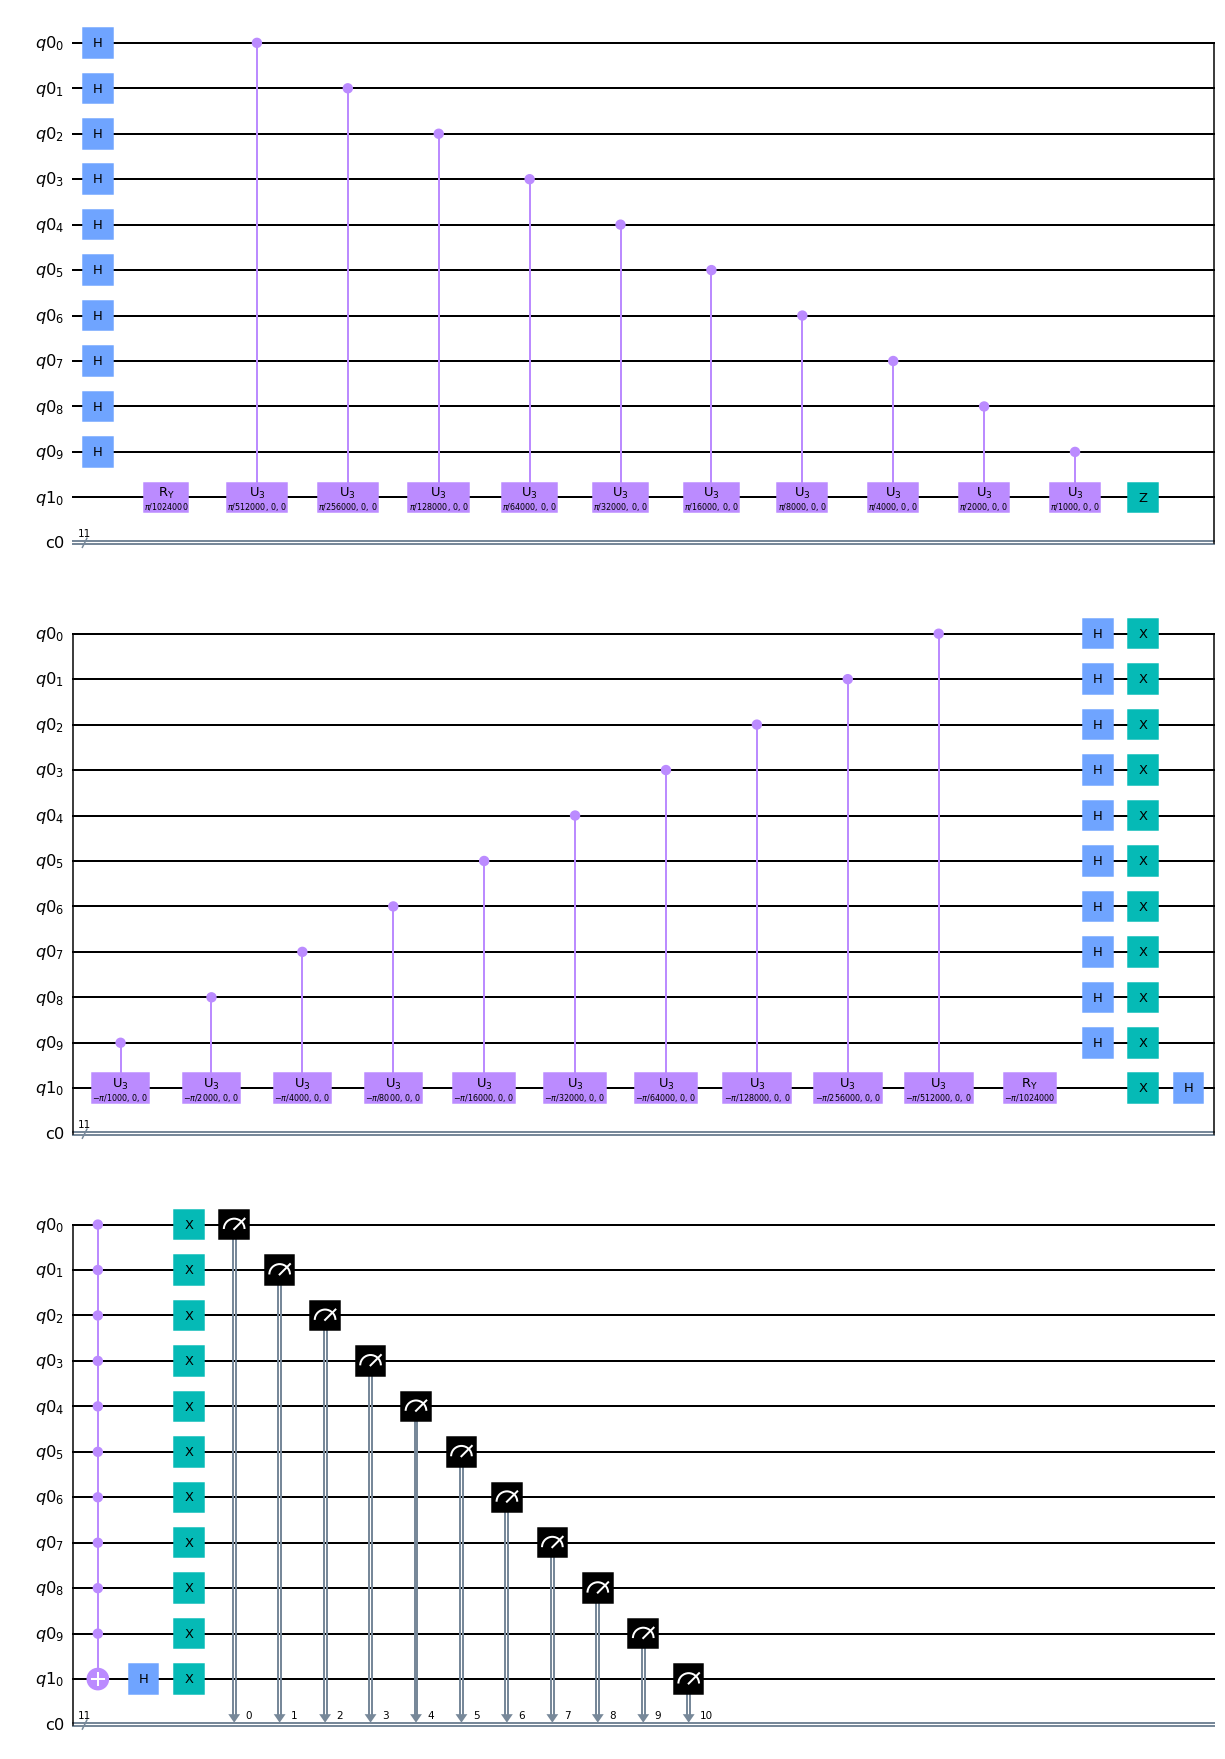

In [5]:
qc_list = create_grover_circuit([1], nbit, b_max)
my_style = {'usepiformat': True, 'cregbundle': True,'compress': True }
qc_list[0].draw(output="mpl", style=my_style, plot_barriers=False )

## Testing the algorithm with simulators

Let us run the algorithm with simulators

In [6]:
#setting the number of shots and Grover operators.

number_grover_list = [0, 1, 2, 4, 8, 16, 32, 64, 128] # list of number of Grover operators
# number_grover_list = [i for i in range(100)]
shots_list = [100] * len(number_grover_list) # list of number of shots
if len(shots_list) != len(number_grover_list):
    raise Exception(
        'The length of shots_list should be equal to the length of number_grover_list.'
    )

backend = Aer.get_backend('qasm_simulator')

In [7]:
noise_model = NoiseModel()
for qi in range(nbit+1):
    if qi >= 0:
        read_err = ReadoutError([[0.990, 0.010],[0.010,0.990]])
        noise_model.add_readout_error(read_err, [qi])

Finally, we can run the algorithm as below: 

In [8]:
qc_list = create_grover_circuit(number_grover_list, nbit,b_max)  # list of Grover circuits

In [9]:
counts_list = run_grover(qc_list, number_grover_list, shots_list, backend, noise_model=noise_model)  # list of number of grover operators

0 th round with 0 oracles
0.4319477081298828 s
1 th round with 1 oracles
0.01608586311340332 s
2 th round with 2 oracles
0.024630069732666016 s
3 th round with 4 oracles
0.04132795333862305 s
4 th round with 8 oracles
0.0670020580291748 s
5 th round with 16 oracles
0.10189318656921387 s
6 th round with 32 oracles
0.33317112922668457 s
7 th round with 64 oracles
0.48776984214782715 s
8 th round with 128 oracles
1.0024387836456299 s


In [10]:
import pickle
with open("raw_result_p001_q001_piover1000.pkl", "wb") as f:
    pickle.dump(counts_list, f)

In [8]:
import pickle
with open("raw_result_p001_q001_piover1000.pkl", "rb") as f:
    counts_list = pickle.load(f)

In [9]:
hit_list = make_hit_list(counts_list)
print(hit_list)

[91, 92, 91, 95, 93, 87, 91, 91, 69]


## Mitigation

In [10]:
shots = 8192
qr = QuantumRegister(nbit+1)
mit_pattern = [[i] for i in range(nbit+1)]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
job = execute(meas_calibs, backend=Aer.get_backend('qasm_simulator'), shots=shots, noise_model=noise_model)
cal_results = job.result()
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)

In [11]:
meas_filter = InvSGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
mit_counts_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    mit_counts_list.append(x_tilde)
mit_hit_list = make_hit_list(mit_counts_list)
print(mit_hit_list)

strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000029
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000004
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999992
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.000000000000001
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.999999999999999
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000029
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000024
number of positive values:  1024
main process: Done!
strict i

In [15]:
"""
meas_filter = InvSSGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    x_tilde_S_list.append(x_tilde)
mit_hit_S_list = make_hit_list(x_tilde_S_list)
print(mit_hit_S_list)
"""

Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.0752743265069995
number of positive values:  7
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.044761464136275
number of positive values:  8
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.056085627707767
number of positive values:  7
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.0734215508621154
number of positive values:  3
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.0704219033433886
number of positive values:  7
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.0599246974111542
number of positive values:  7
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 

In [12]:
meas_filter = InvSLM0SGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_lm_0_list = [] # K = 0
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    x_tilde_S_lm_0_list.append(x_tilde)
mit_hit_S_lm_0_list = make_hit_list(x_tilde_S_lm_0_list)
print(mit_hit_S_lm_0_list)

Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0756774814297294
sum of mitigated probability vector x_hat_s: 1.0756587937221571
0.0015759468078613281 s
number of positive values:  7
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0453520393952704
sum of mitigated probability vector x_hat_s: 1.045329162240088
0.0022819042205810547 s
number of positive values:  8
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0546947945086025
sum of mitigated probability vector x_hat_s: 1.0546736538065598
0.0019021034240722656 s
number of positive values:  8
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0726112774340912
sum of mitigated probability vector x_hat_s: 1.0725949202303469
0.0012221336364746094 s

In [42]:
meas_filter = InvSLMkSGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_lmk_list = [] # K = 0
for counts in counts_list:
    x_tilde = meas_filter.apply(counts, 1000)
    x_tilde_S_lmk_list.append(x_tilde)
mit_hit_S_lmk_list = make_hit_list(x_tilde_S_lmk_list)
print(mit_hit_S_lmk_list)

Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0752743265069995
sum of mitigated probability vector x_hat_s: 1.0752618157656217
number of positive values:  7
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.044761464136275
sum of mitigated probability vector x_hat_s: 1.0447477193562014
number of positive values:  8
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.056085627707767
sum of mitigated probability vector x_hat_s: 1.0560715676936334
number of positive values:  7
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0734215508621154
sum of mitigated probability vector x_hat_s: 1.073411682965046
number of positive values:  3
main process: Done!
Restriction to labels of y + Lagrange Multiplie

In [13]:
import mooney_etal
importlib.reload(mooney_etal)
from mooney_etal import MooneyEtal
meas_filter = MooneyEtal(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_mooney_list = [] # K = 0
for counts in counts_list:
    x_tilde = meas_filter.apply(counts, 1 / 100)
    x_tilde_mooney_list.append(x_tilde)
mit_hit_mooney100_list = make_hit_list(x_tilde_mooney_list)
print(mit_hit_mooney100_list)

The heuristcs by Mooney et al. + SGS algorithm
{32: 0.012963572849700934, 256: 0.011948750872523896, 336: 0.011122801470111302, 260: 0.010892907523208274, 0: 1.0158210747050223}
sum of counts: 1.0627491074205666
0.0006432533264160156 s
number of positive values:  5
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.0269838032934617, 130: 0.011066025643700843}
sum of counts: 1.0380498289371625
0.00044989585876464844 s
number of positive values:  2
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{12: 0.010870089272811762, 16: 0.011803462102223279, 0: 1.0157247101634752}
sum of counts: 1.0383982615385103
0.0004611015319824219 s
number of positive values:  3
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.060835078543776}
sum of counts: 1.060835078543776
0.0002732276916503906 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.0382636099716733, 1024: 0.013388495294916206, 

In [14]:
meas_filter = MooneyEtal(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_mooney_list = [] # K = 0
for counts in counts_list:
    x_tilde = meas_filter.apply(counts, 1 / 10)
    x_tilde_mooney_list.append(x_tilde)
mit_hit_mooney10_list = make_hit_list(x_tilde_mooney_list)
print(mit_hit_mooney10_list)

The heuristcs by Mooney et al. + SGS algorithm
{0: 1.0165495432787248}
sum of counts: 1.0165495432787248
0.0003561973571777344 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.0276199772021644}
sum of counts: 1.0276199772021644
0.0002048015594482422 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.0165495432787248}
sum of counts: 1.0165495432787248
0.00018310546875 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.061233039686581}
sum of counts: 1.061233039686581
0.0003478527069091797 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.0388912914826531}
sum of counts: 1.0388912914826531
0.0001850128173828125 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.9717656066923439}
sum of counts: 0.9717656066923439
0.00018

In [17]:
import pickle
with open("hit_list_p001_q001_piover1000.pkl", "wb") as f:
    pickle.dump(hit_list, f)

In [18]:
import pickle
with open("mit_hit_list_p001_q001_piover1000.pkl", "wb") as f:
    pickle.dump(mit_hit_list, f)

In [19]:
import pickle
with open("mit_hit_S_list_p001_q001_piover1000.pkl", "wb") as f:
    pickle.dump(mit_hit_S_list, f)

In [20]:
import pickle
with open("mit_hit_S_lm_0_list_p001_q001_piover1000pkl", "wb")as f:
    pickle.dump(mit_hit_S_lm_0_list, f)

In [55]:
import pickle
with open("mit_hit_mooney_list_p001_q001_piover1000pkl", "wb")as f:
    pickle.dump(mit_hit_mooney_list, f)

Text(0, 0.5, 'number of shots for $|00...0>$')

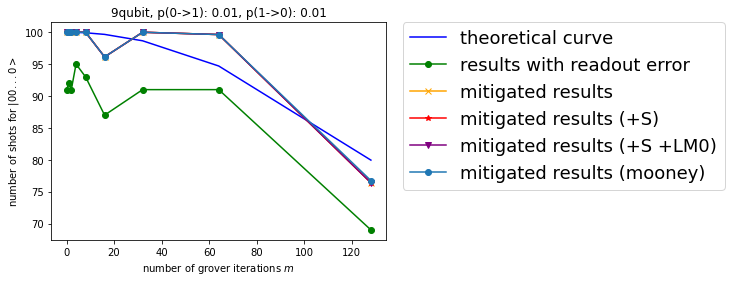

In [61]:
divide = 100
# plt.plot(np.linspace(0,number_grover_list[-1], divide), 100 * np.cos(2 * np.linspace(0,number_grover_list[-1], divide) * np.arccos(np.sqrt(discretizedResult))) ** 2, label="theoretical curve", color="blue")
plt.plot(number_grover_list, 100 * np.cos(2 * np.array(number_grover_list) * np.arccos(np.sqrt(discretizedResult))) ** 2, label="theoretical curve", color="blue")
plt.plot(number_grover_list, hit_list, marker="o", label="results with readout error", color="green")
plt.plot(number_grover_list, mit_hit_list, marker="x", label="mitigated results", color="orange")
plt.plot(number_grover_list, mit_hit_S_list, marker="*", label="mitigated results (+S)", color="red")
plt.plot(number_grover_list, mit_hit_S_lm_0_list, marker="v", label="mitigated results (+S +LM0)", color="purple")
plt.plot(number_grover_list, mit_hit_mooney_list, marker="o", label="mitigated results (mooney)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.title("9qubit, p(0->1): 0.01, p(1->0): 0.01")
plt.xlabel("number of grover iterations $m$")
plt.ylabel("number of shots for $|00...0>$")

## Post-processing

In [15]:
sin_hit_list = [100 - h for h in hit_list]
sin_mit_hit_S_lm_0_list = [100 - h for h in mit_hit_S_lm_0_list]
sin_mit_hit_mooney100_list = [100 - h for h in mit_hit_mooney100_list]
sin_mit_hit_mooney10_list = [100 - h for h in mit_hit_mooney10_list]

thetaCandidate_list = calculate_theta(
    sin_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_S_lm_0_list = calculate_theta(
    sin_mit_hit_S_lm_0_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_mooney100_list = calculate_theta(
    sin_mit_hit_mooney100_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_mooney10_list = calculate_theta(
    sin_mit_hit_mooney10_list, number_grover_list, shots_list)  # list of estimated theta values

error_list = np.abs(np.sin(thetaCandidate_list)**2 - discretizedResult)  # list of estimation errors
error_mit_S_lm_0_list = np.abs(np.sin(thetaCandidate_mit_S_lm_0_list)**2 - discretizedResult)  # list of estimation errors
error_mit_mooney100_list = np.abs(np.sin(thetaCandidate_mit_mooney100_list)**2 - discretizedResult)  # list of estimation errors
error_mit_mooney10_list = np.abs(np.sin(thetaCandidate_mit_mooney10_list)**2 - discretizedResult)  # list of estimation errors
OracleCall_list = []  # list of number of oracle calls
ErrorCramérRao_list = []  # list of Cramér-Rao lower bound
for i in range(len(number_grover_list)):
    OracleCall_list.append(
        CalcNumberOracleCalls(i, shots_list, number_grover_list))
    ErrorCramérRao_list.append(
        CalcErrorCramérRao(i, shots_list, discretizedResult, number_grover_list))

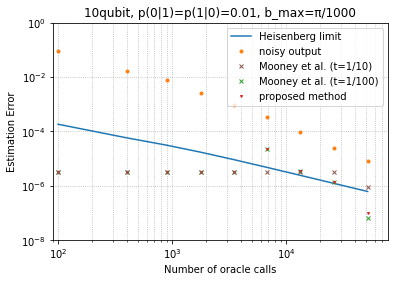

In [17]:
plt.clf()
p = plt.loglog( OracleCall_list, ErrorCramérRao_list)
p0 = plt.loglog( OracleCall_list, error_list, 'o', markersize=3)
p2 = plt.loglog( OracleCall_list, error_mit_mooney100_list, 'x', color='C2', markersize=4)
p3 = plt.loglog( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3', markersize=2)
p4 = plt.loglog( OracleCall_list, error_mit_mooney10_list, 'x', color='C5', markersize=4)

plt.title("10qubit, p(0|1)=p(1|0)=0.01, b_max=π/1000")
plt.xlim(OracleCall_list[0]*0.9, OracleCall_list[-1]*1.5)
plt.xlabel("Number of oracle calls")
plt.ylim(0.00000001, 1)
plt.ylabel("Estimation Error")
plt.grid(True, which="both", ls="dotted")
plt.legend((p[0], p0[0], p4[0], p2[0], p3[0]), ("Heisenberg limit", "noisy output", "Mooney et al. (t=1/10)", "Mooney et al. (t=1/100)", "proposed method"))
plt.show()

In [ ]:
plt.clf()
p = plt.loglog( OracleCall_list, ErrorCramérRao_list)
p0 = plt.loglog( OracleCall_list, error_list, 'o', markersize=3)
p1 = plt.loglog( OracleCall_list, error_mit_list, '*', color='C4', markersize=6)
# p2 = plt.plot( OracleCall_list, error_mit_S_list, 'x', color='C2', markersize=4)
p3 = plt.loglog( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3', markersize=2)

plt.title("10qubit, p(0|1)=p(1|0)=0.01, b_max=π/1000")
plt.xlim(OracleCall_list[0]*0.9, OracleCall_list[-1]*1.5)
plt.xlabel("Number of oracle calls")
plt.ylim(0.00000001, 1)
plt.ylabel("Estimation Error")
plt.grid(True, which="both", ls="dotted")
plt.legend((p[0], p0[0], p1[0], p3[0]), ("Heisenberg limit", "noisy output", "rigorous mitigation", "proposed method"))
plt.show()